# __Training and tuning the neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 2/3

## Authorship:
        Caio Azevedo
        São Paulo University, February, 2024

## Main goals:

- Data processing for neural network application:
   - Elimination of extraneous features.
   - Normalization of the dataset.
   - ANN training, testing and validation dataset split.

- Training and evaluation of neural networks:
   - Custom neural network implementation.
   - Keras neural network implementation.
   
- Automation of hyperparameter setup for improved performance (criterion: accuracy).
   - Brute force for optimizing hyperparameters in the custom network.
   - Keras Tuning for optimizing Keras hyperparameters.
   
- Neural network performance assessment with and without 'less important features'.

- Compare custom ANN with Keras framework

## Coding

### Imported libraries

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

### Auxiliary functions

In [6]:
# Compute and display performance metrics 
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [7]:
# Compute and print ROC curve
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('AUC ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_real))]
    p_fpr, p_tpr, _ = roc_curve(y_real, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='random', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ANN', color='blue')
    
    # axis labels
    pyplot.xlabel('false positive rate')
    pyplot.ylabel('true positive rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [8]:
# split data into training, validation and testing sets
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [9]:
# Plot a bubble chart with two features according to NN classification
def bubble_chart(data, col_2_buble_size, col_x, col_y):
    fig, ax = plt.subplots(figsize=(15,13))
    sizes = data[col_2_buble_size]*10
    scatter = ax.scatter(data[col_x], data[col_y], 
           c=(data['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    ax.title.set_text("{}{}".format(len(data.index), ' landslides samples')) 

    plt.show()

In [10]:
# Plot a bubble chart with two features according to NN classification and the actual values
def  bubble_double_chart(data, col_2_buble_size, col_x, col_y, accuracy):
    sizes = data[col_2_buble_size]*10

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

    scatter = axes[0].scatter(data[col_x], data[col_y],
            c=(data['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    scatter = axes[1].scatter(data[col_x], data[col_y],
            c=(data['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    fig.tight_layout()
    text = 'predicted landslides ' + 'accuracy : {:.2f}%'.format(accuracy)
    axes[0].title.set_text('actual landslides')
    axes[1].title.set_text(text)

    plt.show()

In [11]:
def out_file_name(input_file_name):
    folder_bestANN = 'bestANN\\'
    
    if not os.path.exists(folder_bestANN):
      os.mkdir(folder_bestANN)
    
    out_f = os.path.splitext(input_file_name)[0]
    
    out_NN_custom = folder_bestANN + 'customNN_' + out_f + '.pkl'
    out_NN_keras  = folder_bestANN + 'kerasNN_' + out_f
    
    return out_NN_custom, out_NN_keras

### Select the dataset

- Switch one among the nine samples used in this study. The samples are configured according to the landslides' non-occurrence points' distance from the respective occurrence spot.

In [12]:
APP_PATH = os.getcwd()
#file = "guaruja_radius_50m_shuffled.csv"
#file = "guaruja_radius_100m_shuffled.csv"
#file = "guaruja_radius_150m_shuffled.csv"
#file = "guaruja_radius_200m_shuffled.csv"

#file = "guaruja_buffer_1km_shuffled.csv"
#file = "guaruja_buffer_2km_shuffled.csv"
#file = "guaruja_buffer_3km_shuffled.csv"
#file = "guaruja_buffer_4km_shuffled.csv"

file = "guaruja_random.csv"

dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

# load the dataset
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,174,380188.0000,7355077.000,4.319798,-0.015372,33.860043,25.912239,277.485138,65,90,1
1,1,369756.0000,7344220.000,16.590740,-0.043386,0.727488,0.418544,159.017288,2,90,0
2,62,376611.0000,7353497.000,16.493561,-0.011949,1.114157,1.117189,142.506317,2,90,0
3,110,372569.0000,7346250.000,5.782696,-0.010980,20.309313,9.144706,306.605927,2,30,1
4,109,370946.0334,7346022.025,4.132583,-0.000184,43.904831,46.628563,316.640686,2,30,1


In [13]:
dataset.shape

(197, 11)

In [14]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
count,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.0
mean,99.00,375519.78,7350881.70,5.82,0.12,19.82,47.63,200.24,33.34,69.64,0.5
std,57.01,3796.70,4126.95,3.01,2.04,12.34,54.07,105.75,31.58,29.94,0.5
min,1.00,366577.00,7344020.00,1.37,-18.47,0.03,0.00,0.30,2.00,20.00,0.0
25%,50.00,372439.00,7347513.00,4.03,-0.02,11.59,7.82,108.77,2.00,30.00,0.0
50%,99.00,375221.00,7348949.00,4.96,-0.00,20.69,25.91,202.57,2.00,90.00,1.0
75%,148.00,379188.00,7354877.00,6.41,0.02,27.52,69.85,302.54,65.00,90.00,1.0
max,197.00,381355.00,7357501.00,16.59,11.10,68.52,230.08,359.51,65.00,120.00,1.0


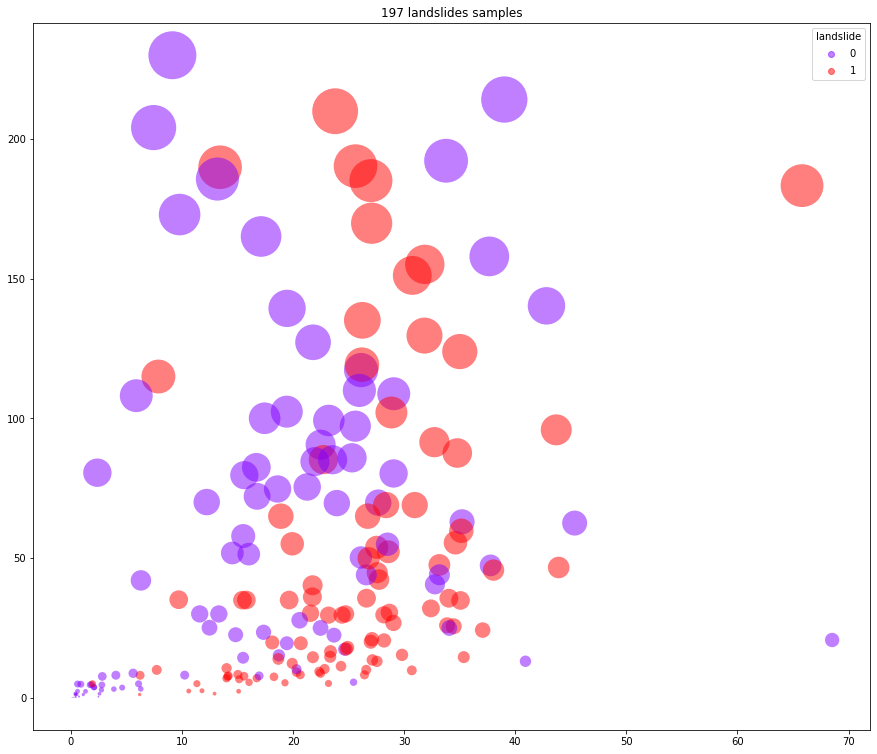

In [15]:
bubble_chart(dataset,"elevation","slope","elevation")

### Data Preparation
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.

 - About most important features in best performed samples

  - Considering the random and 200m samples those with the best performance.
  - According to previous analyses we notice some features are less relevant than others.

     - In the scenario of a random sample, the pivotal features are identified as **twi**, **elevation**, and **land_use**. The overall accuracy, achieved with the optimal configuration using only these features, stands at approximately 98.50%, while utilizing all features yields a consistent 99% accuracy.

     - In instances where an event does not occur within a 200-meter radius of the sample occurrence, the most crucial features include **slope**, **twi**, **aspect**, and **curvature**. The overall accuracy, achieved with the best configuration using these features, is approximately 94.92%, compared to 93.91% when utilizing all features, a result that remains consistent.

After conducting numerous tests, it has been observed that the accuracy of the Artificial Neural Network (ANN) remains largely consistent, whether the most crucial features are included or not. Consequently, the decision has been made to retain all features in the model.

In [16]:
dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]

#dataset = dataset.drop('slope',axis=1)
#dataset = dataset.drop('aspect',axis=1)

#dataset = dataset.drop('lithology',axis=1)
#dataset = dataset.drop('curvature',axis=1)

#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('land_use',axis=1)

#dataset.head(5)

In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation(dataset)

In [18]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

95 train examples
42 validation examples
60 test examples


In [19]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [1.08254853 1.03161732 1.1480696  1.85714286 1.         0.81881985
 2.3282485 ]


In [20]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [21]:
X.shape

(197, 7)

In [22]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [23]:
y.shape

(197, 1)

In [24]:
print(X.min(axis=0), X.max(axis=0))

[-1.00192557 -1.         -1.00014224 -1.         -1.         -1.16903795
 -6.80518688] [1.08254853 1.03161732 1.1480696  1.85714286 1.         1.
 3.56467966]


__Compute the number of input and output features__

In [25]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

### Custom neural network training

#### Hyperparameters tunning
- Brute force method
- Custom implementation for classes and functions

In [26]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [27]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [28]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #input layer
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    #output layer
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [29]:
# (batch_size) Implements the mini-batch that accelerates the training time, requires a mini-batch initialization method. 
#It is ideal for the batch size to be a multiple of the training dataset size, which is 128 here.
neurons = [7,8,12] 
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [30]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('To {} neurons, {} layer(s),  {} learning rate, {} batch size, {} dropout rate, we have: \033[1m Accuracy: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 1.00331688 + 0.00000000 = 1.00331688 loss_val = 1.00331688
epoch: 3000/40000 loss_train: 0.57662745 + 0.00000000 = 0.57662745 loss_val = 0.57662745
epoch: 6000/40000 loss_train: 0.49347102 + 0.00000000 = 0.49347102 loss_val = 0.49347102
epoch: 9000/40000 loss_train: 0.45342407 + 0.00000000 = 0.45342407 loss_val = 0.45342407
epoch: 12000/40000 loss_train: 0.42941358 + 0.00000000 = 0.42941358 loss_val = 0.42941358
epoch: 15000/40000 loss_train: 0.41294018 + 0.00000000 = 0.41294018 loss_val = 0.41294018
epoch: 18000/40000 loss_train: 0.39844635 + 0.00000000 = 0.39844635 loss_val = 0.39844635
epoch: 21000/40000 loss_train: 0.38649867 + 0.00000000 = 0.38649867 loss_val = 0.38649867
epoch: 24000/40000 loss_train: 0.37547711 + 0.00000000 = 0.37547711 loss_val = 0.37547711
epoch: 27000/40000 loss_train: 0.36521648 + 0.00000000 = 0.36521648 loss_val = 0.36521648
epoch: 30000/40000 loss_train: 0.35276641 + 0.00000000 = 0.35276641 loss_val = 0.35276641
epoch: 33000/4

epoch: 3000/40000 loss_train: 0.46722788 + 0.00000000 = 0.46722788 loss_val = 0.46722788
epoch: 6000/40000 loss_train: 0.39723829 + 0.00000000 = 0.39723829 loss_val = 0.39723829
epoch: 9000/40000 loss_train: 0.35148104 + 0.00000000 = 0.35148104 loss_val = 0.35148104
epoch: 12000/40000 loss_train: 0.30901227 + 0.00000000 = 0.30901227 loss_val = 0.30901227
epoch: 15000/40000 loss_train: 0.26658209 + 0.00000000 = 0.26658209 loss_val = 0.26658209
epoch: 18000/40000 loss_train: 0.22652098 + 0.00000000 = 0.22652098 loss_val = 0.22652098
epoch: 21000/40000 loss_train: 0.19334684 + 0.00000000 = 0.19334684 loss_val = 0.19334684
epoch: 24000/40000 loss_train: 0.16961691 + 0.00000000 = 0.16961691 loss_val = 0.16961691
epoch: 27000/40000 loss_train: 0.15523207 + 0.00000000 = 0.15523207 loss_val = 0.15523207
epoch: 30000/40000 loss_train: 0.14742315 + 0.00000000 = 0.14742315 loss_val = 0.14742315
epoch: 33000/40000 loss_train: 0.14223121 + 0.00000000 = 0.14223121 loss_val = 0.14223121
epoch: 36000/

To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 85.71% 
epoch:    0/40000 loss_train: 0.76731169 + 0.00000000 = 0.76731169 loss_val = 0.76731169
epoch: 3000/40000 loss_train: 0.38196200 + 0.00000000 = 0.38196200 loss_val = 0.38196200
epoch: 6000/40000 loss_train: 0.30713989 + 0.00000000 = 0.30713989 loss_val = 0.30713989
epoch: 9000/40000 loss_train: 0.25398488 + 0.00000000 = 0.25398488 loss_val = 0.25398488
epoch: 12000/40000 loss_train: 0.17846781 + 0.00000000 = 0.17846781 loss_val = 0.17846781
epoch: 15000/40000 loss_train: 0.12704070 + 0.00000000 = 0.12704070 loss_val = 0.12704070
epoch: 18000/40000 loss_train: 0.10087133 + 0.00000000 = 0.10087133 loss_val = 0.10087133
To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 76.19% 
epoch:    0/40000 loss_train: 0.68007222 + 0.00000000 = 0.68007222 loss_val = 0.68007222
epoch: 3000/40000 loss_train: 0.46962382 + 0.00000000 = 0.46962382 loss_v

epoch: 18000/40000 loss_train: 0.49145470 + 0.00000000 = 0.49145470 loss_val = 0.49145470
epoch: 21000/40000 loss_train: 0.47791198 + 0.00000000 = 0.47791198 loss_val = 0.47791198
epoch: 24000/40000 loss_train: 0.46605455 + 0.00000000 = 0.46605455 loss_val = 0.46605455
epoch: 27000/40000 loss_train: 0.45346612 + 0.00000000 = 0.45346612 loss_val = 0.45346612
epoch: 30000/40000 loss_train: 0.44064054 + 0.00000000 = 0.44064054 loss_val = 0.44064054
epoch: 33000/40000 loss_train: 0.42918372 + 0.00000000 = 0.42918372 loss_val = 0.42918372
epoch: 36000/40000 loss_train: 0.41837355 + 0.00000000 = 0.41837355 loss_val = 0.41837355
epoch: 39000/40000 loss_train: 0.40769094 + 0.00000000 = 0.40769094 loss_val = 0.40769094
To 8 neurons, 1 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 76.19% 
epoch:    0/40000 loss_train: 1.15483584 + 0.00000000 = 1.15483584 loss_val = 1.15483584
epoch: 3000/40000 loss_train: 0.57711526 + 0.00000000 = 0.57711526 loss_val = 0.57711

epoch: 33000/40000 loss_train: 0.05557502 + 0.00000000 = 0.05557502 loss_val = 0.05557502
epoch: 36000/40000 loss_train: 0.04560984 + 0.00000000 = 0.04560984 loss_val = 0.04560984
epoch: 39000/40000 loss_train: 0.03787634 + 0.00000000 = 0.03787634 loss_val = 0.03787634
To 8 neurons, 1 layer(s),  0.005 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 83.33% 
epoch:    0/40000 loss_train: 0.82216803 + 0.00000000 = 0.82216803 loss_val = 0.82216803
epoch: 3000/40000 loss_train: 0.44818442 + 0.00000000 = 0.44818442 loss_val = 0.44818442
epoch: 6000/40000 loss_train: 0.38365565 + 0.00000000 = 0.38365565 loss_val = 0.38365565
epoch: 9000/40000 loss_train: 0.34608757 + 0.00000000 = 0.34608757 loss_val = 0.34608757
epoch: 12000/40000 loss_train: 0.31308351 + 0.00000000 = 0.31308351 loss_val = 0.31308351
epoch: 15000/40000 loss_train: 0.26897844 + 0.00000000 = 0.26897844 loss_val = 0.26897844
epoch: 18000/40000 loss_train: 0.22979245 + 0.00000000 = 0.22979245 loss_val = 0.2297924

epoch: 21000/40000 loss_train: 0.04330045 + 0.00000000 = 0.04330045 loss_val = 0.04330045
epoch: 24000/40000 loss_train: 0.03418019 + 0.00000000 = 0.03418019 loss_val = 0.03418019
epoch: 27000/40000 loss_train: 0.02670177 + 0.00000000 = 0.02670177 loss_val = 0.02670177
epoch: 30000/40000 loss_train: 0.02087014 + 0.00000000 = 0.02087014 loss_val = 0.02087014
epoch: 33000/40000 loss_train: 0.01644645 + 0.00000000 = 0.01644645 loss_val = 0.01644645
epoch: 36000/40000 loss_train: 0.01320202 + 0.00000000 = 0.01320202 loss_val = 0.01320202
epoch: 39000/40000 loss_train: 0.01080232 + 0.00000000 = 0.01080232 loss_val = 0.01080232
To 8 neurons, 1 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 83.33% 
epoch:    0/40000 loss_train: 0.69591983 + 0.00000000 = 0.69591983 loss_val = 0.69591983
epoch: 3000/40000 loss_train: 0.41101610 + 0.00000000 = 0.41101610 loss_val = 0.41101610
epoch: 6000/40000 loss_train: 0.32673589 + 0.00000000 = 0.32673589 loss_val = 0.3267358

epoch: 3000/40000 loss_train: 0.57459242 + 0.00000000 = 0.57459242 loss_val = 0.57459242
epoch: 6000/40000 loss_train: 0.52664185 + 0.00000000 = 0.52664185 loss_val = 0.52664185
epoch: 9000/40000 loss_train: 0.50547451 + 0.00000000 = 0.50547451 loss_val = 0.50547451
epoch: 12000/40000 loss_train: 0.49118987 + 0.00000000 = 0.49118987 loss_val = 0.49118987
epoch: 15000/40000 loss_train: 0.47985527 + 0.00000000 = 0.47985527 loss_val = 0.47985527
epoch: 18000/40000 loss_train: 0.46976309 + 0.00000000 = 0.46976309 loss_val = 0.46976309
epoch: 21000/40000 loss_train: 0.45690209 + 0.00000000 = 0.45690209 loss_val = 0.45690209
epoch: 24000/40000 loss_train: 0.44418724 + 0.00000000 = 0.44418724 loss_val = 0.44418724
epoch: 27000/40000 loss_train: 0.42993163 + 0.00000000 = 0.42993163 loss_val = 0.42993163
epoch: 30000/40000 loss_train: 0.41678273 + 0.00000000 = 0.41678273 loss_val = 0.41678273
epoch: 33000/40000 loss_train: 0.40243958 + 0.00000000 = 0.40243958 loss_val = 0.40243958
epoch: 36000/

epoch: 6000/40000 loss_train: 0.36290236 + 0.00000000 = 0.36290236 loss_val = 0.36290236
epoch: 9000/40000 loss_train: 0.25033054 + 0.00000000 = 0.25033054 loss_val = 0.25033054
epoch: 12000/40000 loss_train: 0.19084888 + 0.00000000 = 0.19084888 loss_val = 0.19084888
epoch: 15000/40000 loss_train: 0.13435448 + 0.00000000 = 0.13435448 loss_val = 0.13435448
epoch: 18000/40000 loss_train: 0.10550224 + 0.00000000 = 0.10550224 loss_val = 0.10550224
epoch: 21000/40000 loss_train: 0.08246120 + 0.00000000 = 0.08246120 loss_val = 0.08246120
epoch: 24000/40000 loss_train: 0.06028828 + 0.00000000 = 0.06028828 loss_val = 0.06028828
epoch: 27000/40000 loss_train: 0.03391286 + 0.00000000 = 0.03391286 loss_val = 0.03391286
epoch: 30000/40000 loss_train: 0.02162619 + 0.00000000 = 0.02162619 loss_val = 0.02162619
epoch: 33000/40000 loss_train: 0.01445877 + 0.00000000 = 0.01445877 loss_val = 0.01445877
epoch: 36000/40000 loss_train: 0.00999126 + 0.00000000 = 0.00999126 loss_val = 0.00999126
epoch: 39000

epoch: 3000/40000 loss_train: 0.56922139 + 0.00000000 = 0.56922139 loss_val = 0.56922139
epoch: 6000/40000 loss_train: 0.51677016 + 0.00000000 = 0.51677016 loss_val = 0.51677016
epoch: 9000/40000 loss_train: 0.48761089 + 0.00000000 = 0.48761089 loss_val = 0.48761089
epoch: 12000/40000 loss_train: 0.46997426 + 0.00000000 = 0.46997426 loss_val = 0.46997426
epoch: 15000/40000 loss_train: 0.45968501 + 0.00000000 = 0.45968501 loss_val = 0.45968501
epoch: 18000/40000 loss_train: 0.45192479 + 0.00000000 = 0.45192479 loss_val = 0.45192479
epoch: 21000/40000 loss_train: 0.44230960 + 0.00000000 = 0.44230960 loss_val = 0.44230960
epoch: 24000/40000 loss_train: 0.43326485 + 0.00000000 = 0.43326485 loss_val = 0.43326485
epoch: 27000/40000 loss_train: 0.41958845 + 0.00000000 = 0.41958845 loss_val = 0.41958845
epoch: 30000/40000 loss_train: 0.40934510 + 0.00000000 = 0.40934510 loss_val = 0.40934510
epoch: 33000/40000 loss_train: 0.40042459 + 0.00000000 = 0.40042459 loss_val = 0.40042459
epoch: 36000/

epoch: 30000/40000 loss_train: 0.02408432 + 0.00000000 = 0.02408432 loss_val = 0.02408432
epoch: 33000/40000 loss_train: 0.02216461 + 0.00000000 = 0.02216461 loss_val = 0.02216461
epoch: 36000/40000 loss_train: 0.02078696 + 0.00000000 = 0.02078696 loss_val = 0.02078696
epoch: 39000/40000 loss_train: 0.01975471 + 0.00000000 = 0.01975471 loss_val = 0.01975471
To 7 neurons, 2 layer(s),  0.005 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 83.33% 
epoch:    0/40000 loss_train: 0.66863151 + 0.00000000 = 0.66863151 loss_val = 0.66863151
epoch: 3000/40000 loss_train: 0.46753673 + 0.00000000 = 0.46753673 loss_val = 0.46753673
epoch: 6000/40000 loss_train: 0.34009789 + 0.00000000 = 0.34009789 loss_val = 0.34009789
epoch: 9000/40000 loss_train: 0.22266018 + 0.00000000 = 0.22266018 loss_val = 0.22266018
To 7 neurons, 2 layer(s),  0.005 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 83.33% 
epoch:    0/40000 loss_train: 0.74816918 + 0.00000000 = 0.74816918 los

epoch: 12000/40000 loss_train: 0.46194842 + 0.00000000 = 0.46194842 loss_val = 0.46194842
epoch: 15000/40000 loss_train: 0.44192133 + 0.00000000 = 0.44192133 loss_val = 0.44192133
epoch: 18000/40000 loss_train: 0.41846004 + 0.00000000 = 0.41846004 loss_val = 0.41846004
epoch: 21000/40000 loss_train: 0.39582089 + 0.00000000 = 0.39582089 loss_val = 0.39582089
epoch: 24000/40000 loss_train: 0.37161933 + 0.00000000 = 0.37161933 loss_val = 0.37161933
epoch: 27000/40000 loss_train: 0.34538400 + 0.00000000 = 0.34538400 loss_val = 0.34538400
epoch: 30000/40000 loss_train: 0.31814157 + 0.00000000 = 0.31814157 loss_val = 0.31814157
epoch: 33000/40000 loss_train: 0.28103406 + 0.00000000 = 0.28103406 loss_val = 0.28103406
epoch: 36000/40000 loss_train: 0.24363318 + 0.00000000 = 0.24363318 loss_val = 0.24363318
epoch: 39000/40000 loss_train: 0.21226540 + 0.00000000 = 0.21226540 loss_val = 0.21226540
To 8 neurons, 2 layer(s),  0.001 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 80

epoch: 30000/40000 loss_train: 0.01441618 + 0.00000000 = 0.01441618 loss_val = 0.01441618
epoch: 33000/40000 loss_train: 0.01199113 + 0.00000000 = 0.01199113 loss_val = 0.01199113


C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 2 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 47.62% 
epoch:    0/40000 loss_train: 0.70435820 + 0.00000000 = 0.70435820 loss_val = 0.70435820
epoch: 3000/40000 loss_train: 0.48157193 + 0.00000000 = 0.48157193 loss_val = 0.48157193
epoch: 6000/40000 loss_train: 0.41363991 + 0.00000000 = 0.41363991 loss_val = 0.41363991
epoch: 9000/40000 loss_train: 0.34380919 + 0.00000000 = 0.34380919 loss_val = 0.34380919
epoch: 12000/40000 loss_train: 0.28604307 + 0.00000000 = 0.28604307 loss_val = 0.28604307
To 8 neurons, 2 layer(s),  0.005 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 69.05% 
epoch:    0/40000 loss_train: 0.70546322 + 0.00000000 = 0.70546322 loss_val = 0.70546322
epoch: 3000/40000 loss_train: 0.48695627 + 0.00000000 = 0.48695627 loss_val = 0.48695627
epoch: 6000/40000 loss_train: 0.41028591 + 0.00000000 = 0.41028591 loss_val = 0.41028591
epoch: 9000/40000 loss_train: 0.32032639 + 0.00000000 = 0.32032639 loss_v

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 47.62% 
epoch:    0/40000 loss_train: 0.99504067 + 0.00000000 = 0.99504067 loss_val = 0.99504067
epoch: 3000/40000 loss_train: 0.36618480 + 0.00000000 = 0.36618480 loss_val = 0.36618480
epoch: 6000/40000 loss_train: 0.17583354 + 0.00000000 = 0.17583354 loss_val = 0.17583354
To 8 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 80.95% 
epoch:    0/40000 loss_train: 0.80450252 + 0.00000000 = 0.80450252 loss_val = 0.80450252
epoch: 3000/40000 loss_train: 0.25971039 + 0.00000000 = 0.25971039 loss_val = 0.25971039
epoch: 6000/40000 loss_train: 0.06592010 + 0.00000000 = 0.06592010 loss_val = 0.06592010
epoch: 9000/40000 loss_train: 0.02574791 + 0.00000000 = 0.02574791 loss_val = 0.02574791
epoch: 12000/40000 loss_train: 0.01402395 + 0.00000000 = 0.01402395 loss_val = 0.01402395
epoch: 15000/40000 loss_train: 0.00947401 + 0.00000000 = 0.00947401 loss_va

epoch: 24000/40000 loss_train: 0.38627719 + 0.00000000 = 0.38627719 loss_val = 0.38627719
epoch: 27000/40000 loss_train: 0.35549646 + 0.00000000 = 0.35549646 loss_val = 0.35549646
epoch: 30000/40000 loss_train: 0.32380020 + 0.00000000 = 0.32380020 loss_val = 0.32380020
epoch: 33000/40000 loss_train: 0.29182983 + 0.00000000 = 0.29182983 loss_val = 0.29182983
epoch: 36000/40000 loss_train: 0.26705795 + 0.00000000 = 0.26705795 loss_val = 0.26705795
epoch: 39000/40000 loss_train: 0.24695186 + 0.00000000 = 0.24695186 loss_val = 0.24695186
To 12 neurons, 2 layer(s),  0.001 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 76.19% 
epoch:    0/40000 loss_train: 0.78971575 + 0.00000000 = 0.78971575 loss_val = 0.78971575
epoch: 3000/40000 loss_train: 0.60079517 + 0.00000000 = 0.60079517 loss_val = 0.60079517
epoch: 6000/40000 loss_train: 0.54892352 + 0.00000000 = 0.54892352 loss_val = 0.54892352
epoch: 9000/40000 loss_train: 0.49657556 + 0.00000000 = 0.49657556 loss_val = 0.496575

epoch: 21000/40000 loss_train: 0.00410358 + 0.00000000 = 0.00410358 loss_val = 0.00410358
epoch: 24000/40000 loss_train: 0.00279520 + 0.00000000 = 0.00279520 loss_val = 0.00279520
epoch: 27000/40000 loss_train: 0.00206244 + 0.00000000 = 0.00206244 loss_val = 0.00206244
epoch: 30000/40000 loss_train: 0.00160430 + 0.00000000 = 0.00160430 loss_val = 0.00160430
epoch: 33000/40000 loss_train: 0.00129593 + 0.00000000 = 0.00129593 loss_val = 0.00129593
epoch: 36000/40000 loss_train: 0.00107759 + 0.00000000 = 0.00107759 loss_val = 0.00107759
epoch: 39000/40000 loss_train: 0.00091581 + 0.00000000 = 0.00091581 loss_val = 0.00091581
To 12 neurons, 2 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 80.95% 
epoch:    0/40000 loss_train: 0.72915325 + 0.00000000 = 0.72915325 loss_val = 0.72915325
epoch: 3000/40000 loss_train: 0.39724202 + 0.00000000 = 0.39724202 loss_val = 0.39724202
epoch: 6000/40000 loss_train: 0.28912269 + 0.00000000 = 0.28912269 loss_val = 0.289122

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 47.62% 
epoch:    0/40000 loss_train: 0.68299144 + 0.00000000 = 0.68299144 loss_val = 0.68299144
epoch: 3000/40000 loss_train: 0.37210180 + 0.00000000 = 0.37210180 loss_val = 0.37210180
To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 76.19% 
epoch:    0/40000 loss_train: 0.70018294 + 0.00000000 = 0.70018294 loss_val = 0.70018294
epoch: 3000/40000 loss_train: 0.40569712 + 0.00000000 = 0.40569712 loss_val = 0.40569712
epoch: 6000/40000 loss_train: 0.11647389 + 0.00000000 = 0.11647389 loss_val = 0.11647389
epoch: 9000/40000 loss_train: 0.02862053 + 0.00000000 = 0.02862053 loss_val = 0.02862053
epoch: 12000/40000 loss_train: 0.01223939 + 0.00000000 = 0.01223939 loss_val = 0.01223939
epoch: 15000/40000 loss_train: 0.00665453 + 0.00000000 = 0.00665453 loss_val = 0.00665453
epoch: 18000/40000 loss_train: 0.00424218 + 0.00000000 = 0.00424218 loss

epoch: 18000/40000 loss_train: 0.46339517 + 0.00000000 = 0.46339517 loss_val = 0.46339517
epoch: 21000/40000 loss_train: 0.45403605 + 0.00000000 = 0.45403605 loss_val = 0.45403605
epoch: 24000/40000 loss_train: 0.44138219 + 0.00000000 = 0.44138219 loss_val = 0.44138219
epoch: 27000/40000 loss_train: 0.42107016 + 0.00000000 = 0.42107016 loss_val = 0.42107016
epoch: 30000/40000 loss_train: 0.40342931 + 0.00000000 = 0.40342931 loss_val = 0.40342931
epoch: 33000/40000 loss_train: 0.38586997 + 0.00000000 = 0.38586997 loss_val = 0.38586997
epoch: 36000/40000 loss_train: 0.36446082 + 0.00000000 = 0.36446082 loss_val = 0.36446082
epoch: 39000/40000 loss_train: 0.33399163 + 0.00000000 = 0.33399163 loss_val = 0.33399163
To 7 neurons, 3 layer(s),  0.001 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 71.43% 
epoch:    0/40000 loss_train: 0.86298038 + 0.00000000 = 0.86298038 loss_val = 0.86298038
epoch: 3000/40000 loss_train: 0.64811106 + 0.00000000 = 0.64811106 loss_val = 0.64811

epoch: 15000/40000 loss_train: 0.01574453 + 0.00000000 = 0.01574453 loss_val = 0.01574453
epoch: 18000/40000 loss_train: 0.01283753 + 0.00000000 = 0.01283753 loss_val = 0.01283753
epoch: 21000/40000 loss_train: 0.01098628 + 0.00000000 = 0.01098628 loss_val = 0.01098628
epoch: 24000/40000 loss_train: 0.00954944 + 0.00000000 = 0.00954944 loss_val = 0.00954944
epoch: 27000/40000 loss_train: 0.00853340 + 0.00000000 = 0.00853340 loss_val = 0.00853340
epoch: 30000/40000 loss_train: 0.00764572 + 0.00000000 = 0.00764572 loss_val = 0.00764572
epoch: 33000/40000 loss_train: 0.00692720 + 0.00000000 = 0.00692720 loss_val = 0.00692720
epoch: 36000/40000 loss_train: 0.00627836 + 0.00000000 = 0.00627836 loss_val = 0.00627836
epoch: 39000/40000 loss_train: 0.00574351 + 0.00000000 = 0.00574351 loss_val = 0.00574351
To 7 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 83.33% 
epoch:    0/40000 loss_train: 0.98169636 + 0.00000000 = 0.98169636 loss_val = 0.98169

epoch: 3000/40000 loss_train: 0.61594573 + 0.00000000 = 0.61594573 loss_val = 0.61594573
epoch: 6000/40000 loss_train: 0.56241572 + 0.00000000 = 0.56241572 loss_val = 0.56241572
epoch: 9000/40000 loss_train: 0.51288219 + 0.00000000 = 0.51288219 loss_val = 0.51288219
To 8 neurons, 3 layer(s),  0.001 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 64.29% 
epoch:    0/40000 loss_train: 0.83542797 + 0.00000000 = 0.83542797 loss_val = 0.83542797
epoch: 3000/40000 loss_train: 0.65419919 + 0.00000000 = 0.65419919 loss_val = 0.65419919
epoch: 6000/40000 loss_train: 0.58558571 + 0.00000000 = 0.58558571 loss_val = 0.58558571
epoch: 9000/40000 loss_train: 0.50532992 + 0.00000000 = 0.50532992 loss_val = 0.50532992
epoch: 12000/40000 loss_train: 0.46766692 + 0.00000000 = 0.46766692 loss_val = 0.46766692
epoch: 15000/40000 loss_train: 0.42923634 + 0.00000000 = 0.42923634 loss_val = 0.42923634
epoch: 18000/40000 loss_train: 0.39993897 + 0.00000000 = 0.39993897 loss_val = 0.39993897

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.005 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 47.62% 
epoch:    0/40000 loss_train: 0.76206923 + 0.00000000 = 0.76206923 loss_val = 0.76206923
epoch: 3000/40000 loss_train: 0.49078382 + 0.00000000 = 0.49078382 loss_val = 0.49078382
epoch: 6000/40000 loss_train: 0.40522309 + 0.00000000 = 0.40522309 loss_val = 0.40522309
epoch: 9000/40000 loss_train: 0.27234941 + 0.00000000 = 0.27234941 loss_val = 0.27234941
To 8 neurons, 3 layer(s),  0.005 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 83.33% 
epoch:    0/40000 loss_train: 0.87257087 + 0.00000000 = 0.87257087 loss_val = 0.87257087
epoch: 3000/40000 loss_train: 0.32612508 + 0.00000000 = 0.32612508 loss_val = 0.32612508
epoch: 6000/40000 loss_train: 0.08535858 + 0.00000000 = 0.08535858 loss_val = 0.08535858
epoch: 9000/40000 loss_train: 0.01492987 + 0.00000000 = 0.01492987 loss_val = 0.01492987
epoch: 12000/40000 loss_train: 0.00453650 + 0.00000000 = 0.00453650 loss_v

epoch: 6000/40000 loss_train: 0.61006088 + 0.00000000 = 0.61006088 loss_val = 0.61006088
epoch: 9000/40000 loss_train: 0.51838799 + 0.00000000 = 0.51838799 loss_val = 0.51838799
epoch: 12000/40000 loss_train: 0.47315358 + 0.00000000 = 0.47315358 loss_val = 0.47315358
epoch: 15000/40000 loss_train: 0.44865919 + 0.00000000 = 0.44865919 loss_val = 0.44865919
epoch: 18000/40000 loss_train: 0.43177949 + 0.00000000 = 0.43177949 loss_val = 0.43177949
epoch: 21000/40000 loss_train: 0.41698843 + 0.00000000 = 0.41698843 loss_val = 0.41698843
epoch: 24000/40000 loss_train: 0.40011133 + 0.00000000 = 0.40011133 loss_val = 0.40011133
epoch: 27000/40000 loss_train: 0.37796071 + 0.00000000 = 0.37796071 loss_val = 0.37796071
epoch: 30000/40000 loss_train: 0.35115535 + 0.00000000 = 0.35115535 loss_val = 0.35115535
epoch: 33000/40000 loss_train: 0.31686656 + 0.00000000 = 0.31686656 loss_val = 0.31686656
epoch: 36000/40000 loss_train: 0.28671016 + 0.00000000 = 0.28671016 loss_val = 0.28671016
epoch: 39000

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 47.62% 
epoch:    0/40000 loss_train: 0.76380270 + 0.00000000 = 0.76380270 loss_val = 0.76380270
epoch: 3000/40000 loss_train: 0.47038002 + 0.00000000 = 0.47038002 loss_val = 0.47038002
epoch: 6000/40000 loss_train: 0.37083180 + 0.00000000 = 0.37083180 loss_val = 0.37083180
epoch: 9000/40000 loss_train: 0.26503766 + 0.00000000 = 0.26503766 loss_val = 0.26503766
To 12 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 73.81% 
epoch:    0/40000 loss_train: 0.89309555 + 0.00000000 = 0.89309555 loss_val = 0.89309555
epoch: 3000/40000 loss_train: 0.52848663 + 0.00000000 = 0.52848663 loss_val = 0.52848663
epoch: 6000/40000 loss_train: 0.32076178 + 0.00000000 = 0.32076178 loss_val = 0.32076178
epoch: 9000/40000 loss_train: 0.17338005 + 0.00000000 = 0.17338005 loss_val = 0.17338005
epoch: 12000/40000 loss_train: 0.08232883 + 0.00000000 = 0.08232883 loss

epoch: 9000/40000 loss_train: 0.00524432 + 0.00000000 = 0.00524432 loss_val = 0.00524432
epoch: 12000/40000 loss_train: 0.00261547 + 0.00000000 = 0.00261547 loss_val = 0.00261547
epoch: 15000/40000 loss_train: 0.00159620 + 0.00000000 = 0.00159620 loss_val = 0.00159620
epoch: 18000/40000 loss_train: 0.00108608 + 0.00000000 = 0.00108608 loss_val = 0.00108608
epoch: 21000/40000 loss_train: 0.00080516 + 0.00000000 = 0.00080516 loss_val = 0.00080516
epoch: 24000/40000 loss_train: 0.00062986 + 0.00000000 = 0.00062986 loss_val = 0.00062986
epoch: 27000/40000 loss_train: 0.00051123 + 0.00000000 = 0.00051123 loss_val = 0.00051123
epoch: 30000/40000 loss_train: 0.00042634 + 0.00000000 = 0.00042634 loss_val = 0.00042634
epoch: 33000/40000 loss_train: 0.00036341 + 0.00000000 = 0.00036341 loss_val = 0.00036341
epoch: 36000/40000 loss_train: 0.00031501 + 0.00000000 = 0.00031501 loss_val = 0.00031501
epoch: 39000/40000 loss_train: 0.00027676 + 0.00000000 = 0.00027676 loss_val = 0.00027676
To 12 neuro

In [31]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append(hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% was the best\033[1m accuracy\033[0m, having {} layer(s),{} neurons, {} of learning rate and {} of batch size as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

92.86% was the best accuracy, having 2 layer(s),7 neurons, 0.01 of learning rate and 4 of batch size as hyperparameters!


In [32]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% was the best\033[1m accuracy\033[0m, with ANN {} '.format(best_ann.acuracia,best_ann.ann))

92.86% was the best accuracy, with ANN <Rede_Neural.NeuralNetwork object at 0x000001614CCE9F40> 


In [33]:
print('{} was the number of anns trained '.format(len(lst_ANN)))
lst_hyperP = []
lst_ANN = []

162 was the number of anns trained 


#### Assessment

In [34]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% as the best\033[1m accurancy\033[0m, {:.2f} average acc {} ANN!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

90.00% accu_test - 92.86% as the best accurancy, 91.43 average acc <Rede_Neural.NeuralNetwork object at 0x000001614CCE9F40> ANN!


In [35]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers,{} neurons, {} of learning rate, {} batch size and {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

92.86% as the best accurancy, configured with 2 layers,7 neurons, 0.01 of learning rate, 4 batch size and 0 dropout rate!


In [36]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [37]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

90.00%, test sample accurancy !


**Second approach** - Configure another ANN with the parameters obtained from the brute-force optimization.

In [38]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [39]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers, {} of learning rate, {} batch size and {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

92.86% as the best accurancy, configured with 2 layers, 0.01 of learning rate, 4 batch size and 0 dropout rate!


In [40]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

90.00%, test sample accurancy !


#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [41]:
NN_custom, NN_keras = out_file_name(file)

In [42]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved in \033[1m{}\033[0m!'.format(accu,NN_custom))
    bestNN.save(NN_custom)
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

90.00%, excellent accuracy for test sample, ANN saved in bestANN\customNN_guaruja_radius_200m_shuffled.pkl!


#### Overall results

In [43]:
y_pred = bestNN.predict(X_train)
print('\033[1mTraining sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_train, y_pred > 0.5)))
NetworkPerformance(y_train, y_pred)

Training sample accuracy: 100.00%
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[38  0]
 [ 0 57]]


In [44]:
y_pred = bestNN.predict(X_val)
print('\033[1mValidation sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_val, y_pred > 0.5)))
NetworkPerformance(y_val, y_pred)

Validation sample accuracy: 92.86%
Accuracy: 0.928571
Precision: 0.913043
Recall: 0.954545
F1 score: 0.933333
Cohens kappa: 0.856492
ROC AUC: 0.970455
[[18  2]
 [ 1 21]]


In [45]:
y_pred = bestNN.predict(X_test)
print('\033[1mTest sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_test, y_pred > 0.5)))
NetworkPerformance(y_test, y_pred)

Test sample accuracy: 90.00%
Accuracy: 0.900000
Precision: 0.850000
Recall: 0.850000
F1 score: 0.850000
Cohens kappa: 0.775000
ROC AUC: 0.876250
[[37  3]
 [ 3 17]]


In [46]:
y_pred = bestNN.predict(X)
print('\033[1mOverall sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y, y_pred > 0.5)))
NetworkPerformance(y, y_pred)

Overall sample accuracy: 95.43%
Accuracy: 0.954315
Precision: 0.950000
Recall: 0.959596
F1 score: 0.954774
Cohens kappa: 0.908622
ROC AUC: 0.958050
[[93  5]
 [ 4 95]]


AUC ROC=0.9580


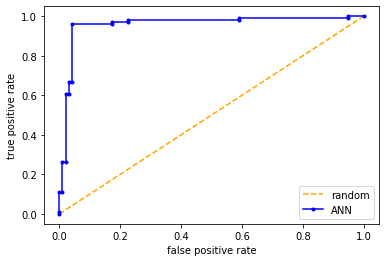

In [47]:
printAUROC(y,y_pred)

In [48]:
cf_matrix = confusion_matrix(y,(y_pred > 0.5))

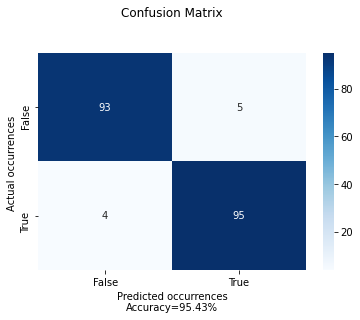

In [49]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAccuracy={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [50]:
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred

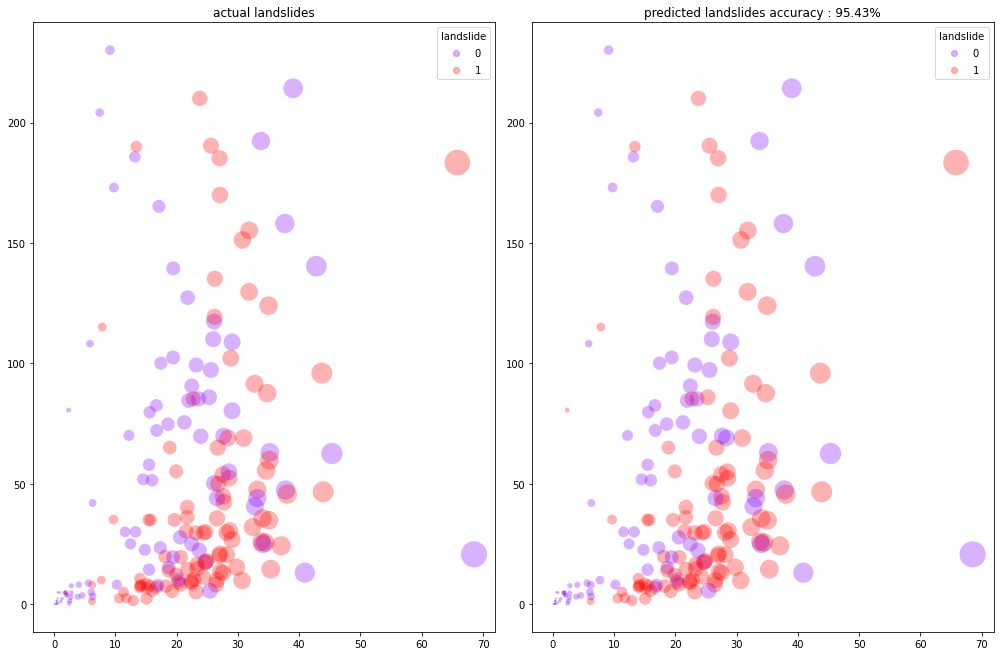

In [51]:
bubble_double_chart(output_dataset,"slope","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

#### RepeatedStratifiedKfold Assessment 

In [52]:
print(X.min(axis=0), X.max(axis=0))

[-1.00192557 -1.         -1.00014224 -1.         -1.         -1.16903795
 -6.80518688] [1.08254853 1.03161732 1.1480696  1.85714286 1.         1.
 3.56467966]


In [53]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Number of Splits_stratified of X: ',rskf.get_n_splits(X, y),'\n')

# Print_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Number of Splits_stratified of X:  10 

(157, 7) (157, 1)
(157, 7) (157, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)
(157, 7) (157, 1)
(157, 7) (157, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)


In [54]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [95.0, 92.5, 92.3076923076923, 100.0, 97.43589743589743, 97.5, 95.0, 92.3076923076923, 97.43589743589743, 94.87179487179486]

Maximum accuracy: 100.0 %

Minimum accuracy: 92.3076923076923 %

Avarage accuracy: 95.43589743589743 %

Standard deviation: 2.624258728462832


In [55]:
dataset

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,33.860043,277.485138,25.912239,90,65,4.319798,-0.015372,1
1,0.727488,159.017288,0.418544,90,2,16.590740,-0.043386,0
2,1.114157,142.506317,1.117189,90,2,16.493561,-0.011949,0
3,20.309313,306.605927,9.144706,30,2,5.782696,-0.010980,1
4,43.904831,316.640686,46.628563,30,2,4.132583,-0.000184,1
...,...,...,...,...,...,...,...,...
192,28.372442,17.409184,68.982224,90,2,4.304924,4.304924,1
193,16.010031,162.229965,51.405090,90,65,5.160524,-2.031868,0
194,23.677940,128.533310,22.392719,90,65,4.225570,-0.711420,0
195,40.913528,28.399397,13.043623,90,2,2.448155,2.316771,0


ROC AUC=0.958


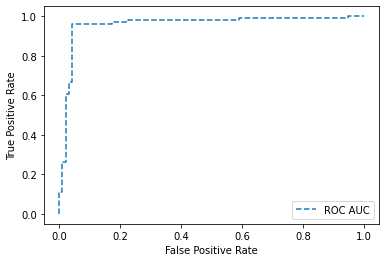

In [56]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [57]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred

Acurácia: 95.43%


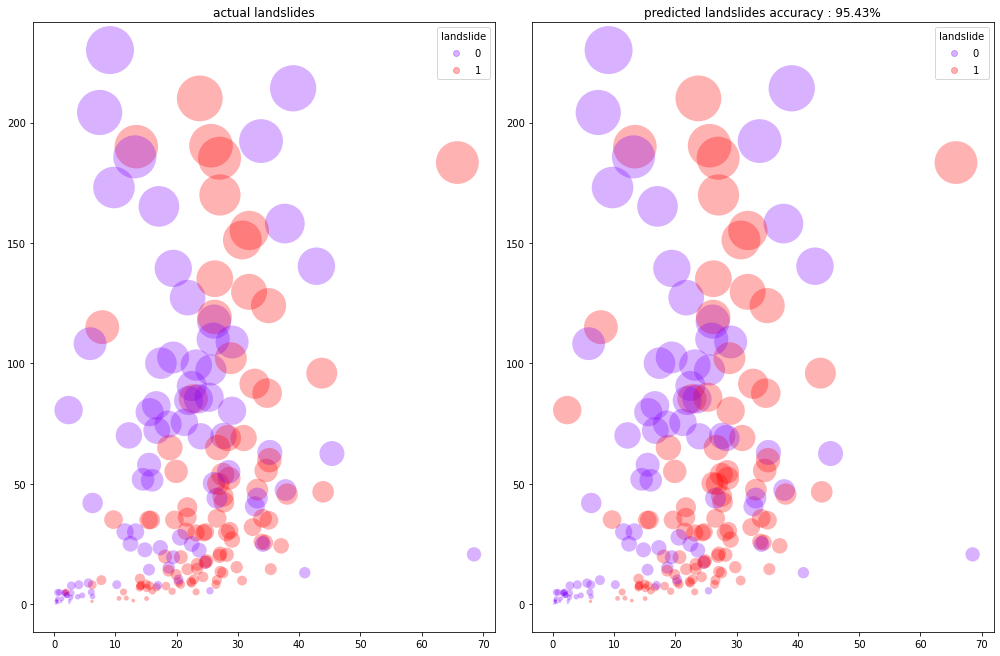

In [58]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

In [59]:
end = datetime.datetime.now()
print(end-start)
#quit()

1:24:59.476892


### Keras Framework
__Clasification problem, see best practices:__
- Hyperparameters tuning
- Baseline to custom implementation 

In [60]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

95 train examples
42 validation examples
60 test examples


In [61]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [62]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
19/19 [==============================] - 4s 10ms/step - loss: 0.7272 - accuracy: 0.4842
Epoch 2/500
19/19 [==============================] - 0s 12ms/step - loss: 0.6974 - accuracy: 0.5684
Epoch 3/500
19/19 [==============================] - 0s 7ms/step - loss: 0.6965 - accuracy: 0.5158
Epoch 4/500
19/19 [==============================] - 0s 6ms/step - loss: 0.6775 - accuracy: 0.5579
Epoch 5/500
19/19 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.5474
Epoch 6/500
19/19 [==============================] - 0s 6ms/step - loss: 0.6784 - accuracy: 0.6316
Epoch 7/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6469 - accuracy: 0.6211
Epoch 8/500
19/19 [==============================] - 0s 6ms/step - loss: 0.6554 - accuracy: 0.5895
Epoch 9/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6576 - accuracy: 0.6105
Epoch 10/500
19/19 [==============================] - 0s 8ms/step - loss: 0.6440 - accuracy: 0.6737
Epoch 1

Epoch 83/500
19/19 [==============================] - 0s 5ms/step - loss: 0.5139 - accuracy: 0.7263
Epoch 84/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4708 - accuracy: 0.7789
Epoch 85/500
19/19 [==============================] - 0s 11ms/step - loss: 0.4930 - accuracy: 0.7579
Epoch 86/500
19/19 [==============================] - 0s 7ms/step - loss: 0.5087 - accuracy: 0.7158
Epoch 87/500
19/19 [==============================] - 0s 7ms/step - loss: 0.5191 - accuracy: 0.7474
Epoch 88/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4594 - accuracy: 0.8211
Epoch 89/500
19/19 [==============================] - 0s 5ms/step - loss: 0.5000 - accuracy: 0.7474
Epoch 90/500
19/19 [==============================] - 0s 8ms/step - loss: 0.4673 - accuracy: 0.7474
Epoch 91/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4814 - accuracy: 0.7895
Epoch 92/500
19/19 [==============================] - 0s 10ms/step - loss: 0.4729 - accuracy: 0.726

19/19 [==============================] - 0s 6ms/step - loss: 0.4600 - accuracy: 0.7895
Epoch 165/500
19/19 [==============================] - 0s 11ms/step - loss: 0.4348 - accuracy: 0.8000
Epoch 166/500
19/19 [==============================] - 0s 14ms/step - loss: 0.4408 - accuracy: 0.7895
Epoch 167/500
19/19 [==============================] - 0s 7ms/step - loss: 0.3798 - accuracy: 0.8211
Epoch 168/500
19/19 [==============================] - 0s 6ms/step - loss: 0.4206 - accuracy: 0.8211
Epoch 169/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4082 - accuracy: 0.8316
Epoch 170/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4412 - accuracy: 0.7789
Epoch 171/500
19/19 [==============================] - 0s 7ms/step - loss: 0.4493 - accuracy: 0.8211
Epoch 172/500
19/19 [==============================] - 0s 8ms/step - loss: 0.3853 - accuracy: 0.8316
Epoch 173/500
19/19 [==============================] - 0s 12ms/step - loss: 0.4145 - accuracy: 0.8421
E

19/19 [==============================] - 0s 5ms/step - loss: 0.3768 - accuracy: 0.8316
Epoch 246/500
19/19 [==============================] - 0s 8ms/step - loss: 0.3178 - accuracy: 0.9158
Epoch 247/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3924 - accuracy: 0.8105
Epoch 248/500
19/19 [==============================] - 0s 5ms/step - loss: 0.3474 - accuracy: 0.8737
Epoch 249/500
19/19 [==============================] - 0s 4ms/step - loss: 0.3670 - accuracy: 0.8316
Epoch 250/500
19/19 [==============================] - 0s 5ms/step - loss: 0.3218 - accuracy: 0.8842
Epoch 251/500
19/19 [==============================] - 0s 6ms/step - loss: 0.3794 - accuracy: 0.8316
Epoch 252/500
19/19 [==============================] - 0s 5ms/step - loss: 0.3455 - accuracy: 0.8632
Epoch 253/500
19/19 [==============================] - 0s 4ms/step - loss: 0.3866 - accuracy: 0.8526
Epoch 254/500
19/19 [==============================] - 0s 4ms/step - loss: 0.3041 - accuracy: 0.9158
Epoc

19/19 [==============================] - 0s 6ms/step - loss: 0.3014 - accuracy: 0.8842
Epoch 327/500
19/19 [==============================] - 0s 12ms/step - loss: 0.3164 - accuracy: 0.8947
Epoch 328/500
19/19 [==============================] - 0s 8ms/step - loss: 0.2830 - accuracy: 0.9053
Epoch 329/500
19/19 [==============================] - 0s 13ms/step - loss: 0.3178 - accuracy: 0.8737
Epoch 330/500
19/19 [==============================] - 0s 8ms/step - loss: 0.3251 - accuracy: 0.8842
Epoch 331/500
19/19 [==============================] - 0s 7ms/step - loss: 0.2735 - accuracy: 0.8842
Epoch 332/500
19/19 [==============================] - 0s 5ms/step - loss: 0.3003 - accuracy: 0.9053
Epoch 333/500
19/19 [==============================] - 0s 6ms/step - loss: 0.2812 - accuracy: 0.8947
Epoch 334/500
19/19 [==============================] - 0s 9ms/step - loss: 0.3249 - accuracy: 0.8737
Epoch 335/500
19/19 [==============================] - 0s 7ms/step - loss: 0.2686 - accuracy: 0.8947
Ep

19/19 [==============================] - 0s 4ms/step - loss: 0.1969 - accuracy: 0.9368
Epoch 408/500
19/19 [==============================] - 0s 4ms/step - loss: 0.2537 - accuracy: 0.8737
Epoch 409/500
19/19 [==============================] - 0s 4ms/step - loss: 0.2180 - accuracy: 0.9158
Epoch 410/500
19/19 [==============================] - 0s 3ms/step - loss: 0.2102 - accuracy: 0.9368
Epoch 411/500
19/19 [==============================] - 0s 2ms/step - loss: 0.2422 - accuracy: 0.9158
Epoch 412/500
19/19 [==============================] - 0s 3ms/step - loss: 0.1981 - accuracy: 0.9684
Epoch 413/500
19/19 [==============================] - 0s 4ms/step - loss: 0.2300 - accuracy: 0.9263
Epoch 414/500
19/19 [==============================] - 0s 3ms/step - loss: 0.2267 - accuracy: 0.9053
Epoch 415/500
19/19 [==============================] - 0s 6ms/step - loss: 0.2090 - accuracy: 0.9579
Epoch 416/500
19/19 [==============================] - 0s 3ms/step - loss: 0.2144 - accuracy: 0.9368
Epoc

19/19 [==============================] - 0s 3ms/step - loss: 0.1818 - accuracy: 0.9474
Epoch 489/500
19/19 [==============================] - 0s 5ms/step - loss: 0.2065 - accuracy: 0.9368
Epoch 490/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1829 - accuracy: 0.9368
Epoch 491/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1794 - accuracy: 0.9579
Epoch 492/500
19/19 [==============================] - 0s 3ms/step - loss: 0.1591 - accuracy: 0.9474
Epoch 493/500
19/19 [==============================] - 0s 4ms/step - loss: 0.1791 - accuracy: 0.9368
Epoch 494/500
19/19 [==============================] - 0s 3ms/step - loss: 0.2353 - accuracy: 0.8947
Epoch 495/500
19/19 [==============================] - 0s 3ms/step - loss: 0.1361 - accuracy: 0.9684
Epoch 496/500
19/19 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9579
Epoch 497/500
19/19 [==============================] - 0s 3ms/step - loss: 0.1498 - accuracy: 0.9579
Epoc

In [63]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 412


In [64]:
# keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 1s 5ms/step - loss: 0.5677 - accuracy: 0.8333
Accuracy: 83.33


In [65]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/412
3/3 [==============================] - 1s 6ms/step - loss: 0.1687 - accuracy: 0.9579
Epoch 2/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1328 - accuracy: 0.9895
Epoch 3/412
3/3 [==============================] - 1s 5ms/step - loss: 0.1527 - accuracy: 0.9895
Epoch 4/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1437 - accuracy: 0.9684
Epoch 5/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1790 - accuracy: 0.9474
Epoch 6/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1514 - accuracy: 0.9579
Epoch 7/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1842 - accuracy: 0.9474
Epoch 8/412
3/3 [==============================] - 0s 3ms/step - loss: 0.1797 - accuracy: 0.9579
Epoch 9/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1515 - accuracy: 0.9368
Epoch 10/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1699 - accuracy: 0.9368
Epoch 11/412
3/3 [===========

3/3 [==============================] - 0s 4ms/step - loss: 0.1725 - accuracy: 0.9579
Epoch 85/412
3/3 [==============================] - 0s 3ms/step - loss: 0.1413 - accuracy: 0.9474
Epoch 86/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1701 - accuracy: 0.9684
Epoch 87/412
3/3 [==============================] - 0s 4ms/step - loss: 0.2030 - accuracy: 0.9053
Epoch 88/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1854 - accuracy: 0.9368
Epoch 89/412
3/3 [==============================] - 0s 5ms/step - loss: 0.2305 - accuracy: 0.9053
Epoch 90/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1653 - accuracy: 0.9474
Epoch 91/412
3/3 [==============================] - 0s 3ms/step - loss: 0.1697 - accuracy: 0.9579
Epoch 92/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1962 - accuracy: 0.9263
Epoch 93/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1320 - accuracy: 0.9684
Epoch 94/412
3/3 [===============

Epoch 167/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1430 - accuracy: 0.9684
Epoch 168/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1811 - accuracy: 0.9368
Epoch 169/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1550 - accuracy: 0.9368
Epoch 170/412
3/3 [==============================] - 0s 3ms/step - loss: 0.1472 - accuracy: 0.9684
Epoch 171/412
3/3 [==============================] - 0s 3ms/step - loss: 0.1501 - accuracy: 0.9684
Epoch 172/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1516 - accuracy: 0.9579
Epoch 173/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1489 - accuracy: 0.9368
Epoch 174/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1561 - accuracy: 0.9579
Epoch 175/412
3/3 [==============================] - 0s 7ms/step - loss: 0.1695 - accuracy: 0.9368
Epoch 176/412
3/3 [==============================] - 0s 11ms/step - loss: 0.1966 - accuracy: 0.9158
Epoch 177

3/3 [==============================] - 0s 7ms/step - loss: 0.1667 - accuracy: 0.9579
Epoch 250/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1473 - accuracy: 0.9474
Epoch 251/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1432 - accuracy: 0.9474
Epoch 252/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1075 - accuracy: 0.9684
Epoch 253/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1654 - accuracy: 0.9368
Epoch 254/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1507 - accuracy: 0.9579
Epoch 255/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1180 - accuracy: 0.9789
Epoch 256/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1288 - accuracy: 0.9684
Epoch 257/412
3/3 [==============================] - 0s 3ms/step - loss: 0.1923 - accuracy: 0.9158
Epoch 258/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1233 - accuracy: 0.9789
Epoch 259/412
3/3 [=====

3/3 [==============================] - 0s 4ms/step - loss: 0.1277 - accuracy: 0.9789
Epoch 332/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1400 - accuracy: 0.9684
Epoch 333/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1284 - accuracy: 0.9789
Epoch 334/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1503 - accuracy: 0.9579
Epoch 335/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1759 - accuracy: 0.9474
Epoch 336/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1576 - accuracy: 0.9368
Epoch 337/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1552 - accuracy: 0.9579
Epoch 338/412
3/3 [==============================] - 0s 5ms/step - loss: 0.1535 - accuracy: 0.9579
Epoch 339/412
3/3 [==============================] - 0s 4ms/step - loss: 0.1735 - accuracy: 0.9368
Epoch 340/412
3/3 [==============================] - 0s 6ms/step - loss: 0.2138 - accuracy: 0.9158
Epoch 341/412
3/3 [=====

#### Assessment

In [66]:
# Keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 4ms/step - loss: 0.5858 - accuracy: 0.8333
Accuracy: 83.33


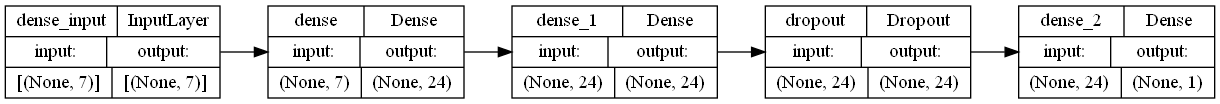

In [67]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [68]:
accu = 100*accuracy

In [69]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved in \033[1m{}\033[0m!'.format(accu,NN_keras))
    hypermodel.save(NN_keras) 
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

Accuracy: 83.33% testing sample accuracy under .85!


#### RepeatedStratifiedKFold Assessment

In [70]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Splits numbers of X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

Splits numbers of X:  10 

2/2 [==============================] - 0s 7ms/step


In [71]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [87.5, 92.5, 87.17948717948718, 97.43589743589743, 89.74358974358975, 92.5, 87.5, 89.74358974358975, 89.74358974358975, 94.87179487179486]

Maximum accuracy: 97.43589743589743 %

Minimum accuracy: 87.17948717948718 %

Avarage accuracy: 90.87179487179488 %

Standard deviation: 3.4087994659998637


In [72]:
y_pred = hypermodel.predict(X_test)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

2/2 [==============================] - 0s 4ms/step
Accuracy: 83.33%


In [73]:
y_pred = hypermodel.predict(X_train)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

3/3 [==============================] - 0s 3ms/step
Accuracy: 97.89%


In [74]:
y_pred = hypermodel.predict(X_val)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

2/2 [==============================] - 0s 5ms/step
Accuracy: 85.71%


In [75]:
y_pred = hypermodel.predict(X)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

7/7 [==============================] - 0s 2ms/step
Accuracy: 90.86%


In [76]:
NetworkPerformance(y, y_pred)

Accuracy: 0.908629
Precision: 0.871560
Recall: 0.959596
F1 score: 0.913462
Cohens kappa: 0.817160
ROC AUC: 0.941352
[[84 14]
 [ 4 95]]


ROC AUC=0.941


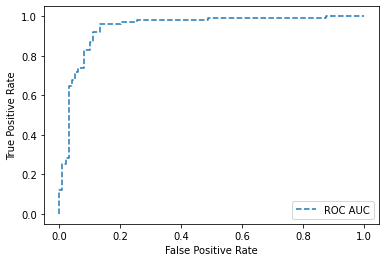

In [77]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

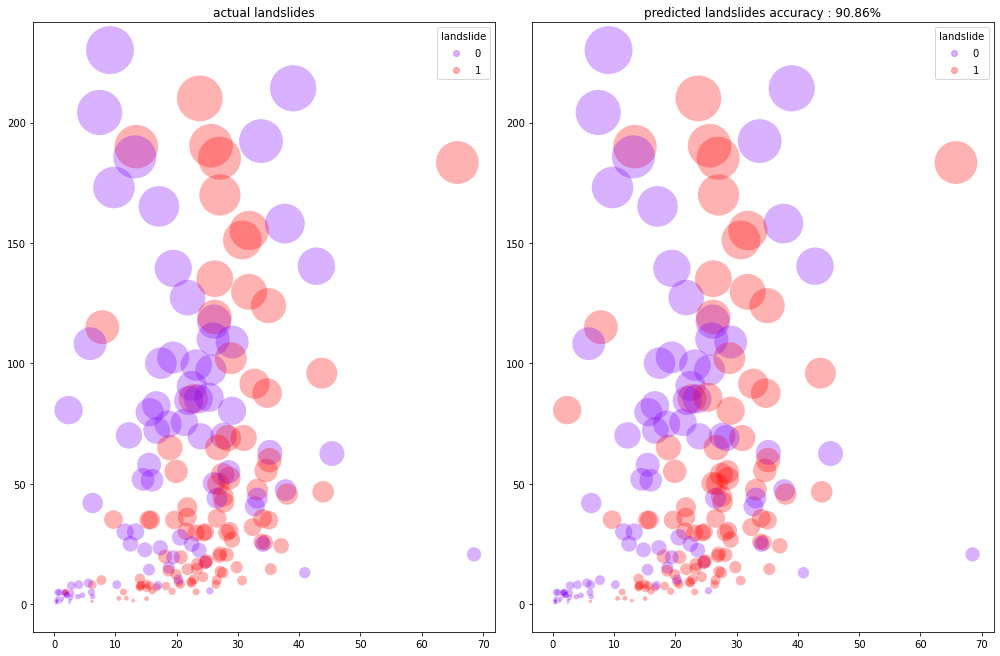

In [78]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

In [79]:
end = datetime.datetime.now()
print(end-start)

1:26:25.042803


## References
- ref.1: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref.2: https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref.3: https://realpython.com/train-test-split-python-data/
- ref.4: https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref.5: https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref.6: https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref.7: https://www.section.io/engineering-education/data-leakage/
- ref.8: https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref.9: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
- ref. 10: https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb
- ref. 11: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
- ref. 12: http://karpathy.github.io/2019/04/25/recipe/
- ref. 13: https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
- ref. 14: https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
- ref. 15: https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece
- ref. 16: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. 17: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
- ref. 18: https://machinelearningmastery.com/data-preparation-without-data-leakage/